I'll try to build a QB stat predictor in this notebook. First lets load our full database

In [73]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from scipy.stats.stats import pearsonr 
import math

In [74]:
import pandas as pd
import pickle

samples=pd.read_csv('TrainingSamples.csv')
samples.drop('Unnamed: 0', axis=1, inplace=True)

with open("stat_order.pickle",'rb') as f:
    stat_order=pickle.load(f)

Next, lets remove the first year of football data (since the averages will be bad) and extract all of the QB players

In [75]:
QBsamples=samples[(samples['Position']=="QB") & (samples['Week']>50)].reset_index(drop=True)

In [76]:
len(QBsamples)

2190

All of our lists got saved as strings in csv format, so lets convert them back to lists

In [77]:
all_lists = ['Opp Avg Stats','Opp Stat Std','Opp Avg Stats v Team','Opp Stat Std v Team',\
             'Opp Players','Player Avg Stats','Player Stat Std','Player Avg Stats v Opp',\
             'Player Stat Std v Opp','Team Avg Stats','Team Stat Std','Team Avg v Opp',\
             'Team Stat Std v Opp','Stat Outcome']

for list in all_lists:
    QBsamples[list] = QBsamples[list].apply(eval)

Next, lets remove any players that have "nan" stats

In [78]:
QBsamples['No Player Stats'] = QBsamples.apply(lambda x: math.isnan(x['Player Avg Stats'][0]), axis = 1)

In [79]:
QBsamples=QBsamples[QBsamples['No Player Stats']==False].reset_index(drop=True)

In [80]:
len(QBsamples)

2141

For now also remove players with very low average targets as well

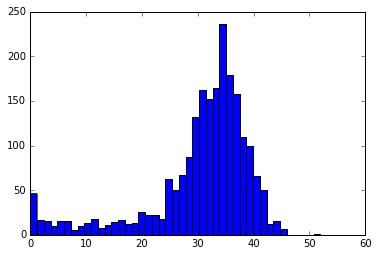

In [81]:
tarHist=np.hstack(QBsamples['Player Avg Stats'].apply(lambda x: x[stat_order.index('passing_att')]))
plt.hist(tarHist, bins='auto')
plt.show()

In [82]:
QBsamples['High Pass']=QBsamples['Player Avg Stats'].apply(lambda x: x[stat_order.index('passing_att')] > 25)
QBsamples=QBsamples[QBsamples['High Pass']==True].reset_index(drop=True)
len(QBsamples)


1769

# Examining feature correlations for receiving yards

We'll need to predict each QB stat separately.  The relevant scoring stats are:

* Passing Yards
* TD passes
* Interception
* 2pt Passing Conversion

Technically, we should try to predict rushing yards, etc as well.. but these are good for a start.

In [83]:
def CalcCorr(x_stat_type,y_stat):
    #x_stat is a stat in stat_order, such as "receiving_yds"
    #x_stat_type is "Player" or "Team" or "Opp"
    for x_stat in stat_order:
        x_dfColumn = '%s Avg Stats' % x_stat_type

        all_x_stats =  QBsamples[x_dfColumn] 
        all_y_stats =  QBsamples['Stat Outcome'] 

        x_stats = all_x_stats.apply(lambda x: x[stat_order.index(x_stat)])
        y_stats = all_y_stats.apply(lambda x: x[stat_order.index(y_stat)])

        if abs(pearsonr(x_stats, y_stats)[0]) > 0.2:
            print x_stat_type, x_stat, "Correlation:", pearsonr(x_stats, y_stats)[0]


In [84]:
CalcCorr('Player','passing_yds')
CalcCorr('Team','passing_yds')    
CalcCorr('Opp','passing_yds')

Player passing_yds Correlation: 0.350674520979
Player passing_tds Correlation: 0.337083990908
Player passing_att Correlation: 0.280800465793
Player passing_cmp Correlation: 0.335618773601
Player passing_cmp_air_yds Correlation: 0.306447582187
Team passing_yds Correlation: 0.289896206518
Team passing_tds Correlation: 0.283392764636
Team receiving_yds Correlation: 0.292057630035
Team receiving_rec Correlation: 0.290719979129
Team receiving_tds Correlation: 0.279782074053
Team passing_att Correlation: 0.211013016674
Team passing_cmp Correlation: 0.28340707273
Team passing_cmp_air_yds Correlation: 0.265452361275
Team receiving_tar Correlation: 0.224780051944
Team receiving_yac_yds Correlation: 0.24070492477
Team kicking_xpa Correlation: 0.242071485334
Team kicking_xpmade Correlation: 0.241277067713


It's pretty surprising that's there is no correlation between the opponent's passing yards allowed and the outcome of the player's passing yards... Let's plot that to look into it a little further

In [85]:
import numpy as np
from scipy.stats import gaussian_kde

def PlotCorr(x_stat,x_stat_type,y_stat):
    #x_stat is a stat in stat_order, such as "receiving_yds"
    #x_stat_type is "Player" or "Team" or "Opp"
    x_dfColumn = '%s Avg Stats' % x_stat_type
    
    all_x_stats =  QBsamples[x_dfColumn] 
    all_y_stats =  QBsamples['Stat Outcome'] 

    x_stats = all_x_stats.apply(lambda x: x[stat_order.index(x_stat)])
    y_stats = all_y_stats.apply(lambda x: x[stat_order.index(y_stat)])

    xy = np.vstack([x_stats,y_stats])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x_stats[idx], y_stats[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50, edgecolor='')
    plt.show()

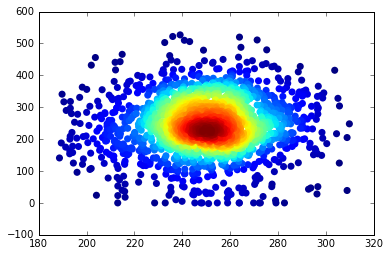

In [86]:
PlotCorr('defense_passing_yds_allowed','Opp','passing_yds')

Interesting... there isn't a huge spread in the allowed passing yards of teams, and there really doesn't look like there's any correlation here.

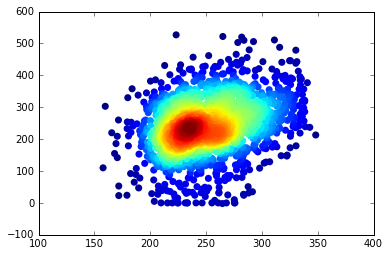

In [87]:
PlotCorr('passing_yds','Team','passing_yds')

For team's passing yards, there are clearly two types of team... a high passing yards group and a low passing yards group.  Surprisingly, the high passing yards group doesn't seem to have higher yards for each player.  Instead, they must be passing to a wider range of players.

# Training a predictor

Okay, for now lets use the seven features that have abs(correlation) > 0.1 to training our predictor.  We might add more features based on our CV results later.

First, we need to split our sample into training, CV, and testing sets.  Let's randomly order our dataframe, using the same seed so that we get the same order every time we run this code.

In [88]:
np.random.seed(42)
QBsamples=QBsamples.reindex(np.random.permutation(QBsamples.index))
QBsamples.reset_index(inplace=True)

Now lets put half of the samples in training, a quarter in CV, and a quarter in test.

In [89]:
QB_training = QBsamples.ix[:round(len(QBsamples)/2)]
QB_cv = QBsamples.ix[round(len(QBsamples)/2): round(len(QBsamples)/2) + round(len(QBsamples)/4)]
QB_test = QBsamples.ix[round(len(QBsamples)/2) + round(len(QBsamples)/4):]

In [90]:
QB_training['Discard']=QB_training['Stat Outcome'].apply(lambda x: x[stat_order.index('passing_yds')]==0)
QB_cv['Discard']=QB_cv['Stat Outcome'].apply(lambda x: x[stat_order.index('passing_yds')]==0)

/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [91]:
QB_training=QB_training[QB_training['Discard']==False]
QB_cv=QB_cv[QB_cv['Discard']==False]

Now lets train a simple prediction model before trying anything fancy. First we'll try a linear regression model, then we'll try a nonlinear regression model, then we'll try a neural network.  As a reminder, here's the features that have a correlation with a player's receiving yard outcome

In [175]:
player_feats=['passing_yds','passing_tds','passing_att','passing_cmp','passing_cmp_air_yds']
team_feats=['passing_yds','receiving_yds','passing_tds']
opp_feats=['defense_int','defense_passing_yds_allowed','defense_points_allowed']

all_feats=[player_feats,team_feats,opp_feats]

In [176]:
#Extract the features we want
def getFeats(row,feats):
    feat_df=pd.DataFrame()
    feat_list=[]
    
    #Player feats
    feat_list= [row['Player Avg Stats'][stat_order.index(feat)] for feat in feats[0]]

    #Team feats
    feat_list = feat_list + [row['Team Avg Stats'][stat_order.index(feat)] for feat in feats[1]]

    #Opponent feats
    feat_list = feat_list + [row['Opp Avg Stats'][stat_order.index(feat)] for feat in feats[2]]

    return feat_list

In [177]:
X_train=pd.DataFrame(QB_training.apply(getFeats,args=[all_feats],axis=1).tolist())
X_cv=pd.DataFrame(QB_cv.apply(getFeats,args=[all_feats],axis=1).tolist())

In [178]:
#Extract feature names for column names
def getFeatNames(feats):
    feat_names=[]
    
    for feat in feats[0]:
        feat_names = feat_names + ['player_%s' % feat]
    for feat in feats[1]:
        feat_names = feat_names + ['team_%s' % feat]
    for feat in feats[2]:
        feat_names = feat_names + ['opp_%s' % feat]
    
    return feat_names

In [179]:
X_train.columns=getFeatNames(all_feats)
X_cv.columns=getFeatNames(all_feats)
X_train.head()

,player_passing_yds,player_passing_tds,player_passing_att,player_passing_cmp,player_passing_cmp_air_yds,team_passing_yds,team_receiving_yds,team_passing_tds,opp_defense_int,opp_defense_passing_yds_allowed,opp_defense_points_allowed
0,231.130435,1.391304,33.260870,19.260870,141.086957,234.260870,234.260870,1.391304,0.565217,217.217391,24.695652
1,298.608696,1.695652,36.739130,22.434783,178.260870,298.782609,298.782609,1.695652,0.636364,259.136364,22.727273
2,220.565217,1.434783,33.565217,20.521739,107.608696,221.652174,228.956522,1.434783,1.391304,214.173913,16.913043
3,249.956522,1.695652,34.869565,21.521739,126.043478,276.000000,255.956522,1.869565,1.086957,224.130435,24.043478
4,277.347826,1.782609,35.304348,21.173913,169.130435,278.173913,278.173913,1.782609,0.869565,230.826087,19.956522


In [180]:
#Scale the features to help with fitting

#Get min and max of each feature in from the data set
def getExtremeOfFeat(feat,feat_type):
    #Player feats
    feat_list = QBsamples.apply(lambda x: x['%s Avg Stats' % feat_type][stat_order.index(feat)],axis=1).tolist()

    return (max(feat_list),min(feat_list))

def scaleFeat(featFrame,feats):
    
    #player feats
    for feat in feats[0]:
        (max_feat,min_feat)=getExtremeOfFeat(feat,'Player')
        featFrame['player_%s' % feat]= (featFrame['player_%s' % feat] - min_feat)/(max_feat-min_feat)
    
    #team feats
    for feat in feats[1]:
        (max_feat,min_feat)=getExtremeOfFeat(feat,'Team')
        featFrame['team_%s' % feat]= (featFrame['team_%s' % feat] - min_feat)/(max_feat-min_feat)
    
    #opp feats
    for feat in feats[2]:
        (max_feat,min_feat)=getExtremeOfFeat(feat,'Opp')
        featFrame['opp_%s' % feat]= (featFrame['opp_%s' % feat] - min_feat)/(max_feat-min_feat)
        
    return featFrame

In [181]:
scaleFeat(X_train,all_feats)
scaleFeat(X_cv,all_feats)
X_train.head()

,player_passing_yds,player_passing_tds,player_passing_att,player_passing_cmp,player_passing_cmp_air_yds,team_passing_yds,team_receiving_yds,team_passing_tds,opp_defense_int,opp_defense_passing_yds_allowed,opp_defense_points_allowed
0,0.494216,0.413631,0.304788,0.330435,0.602550,0.401894,0.349261,0.284075,0.162162,0.235389,0.653084
1,0.788997,0.504113,0.433829,0.457391,0.797177,0.740510,0.665897,0.394548,0.206388,0.581177,0.543981
2,0.448061,0.426557,0.316079,0.380870,0.427271,0.335722,0.323231,0.299857,0.675676,0.210283,0.221711
3,0.576458,0.504113,0.364470,0.420870,0.523788,0.620945,0.455731,0.457676,0.486486,0.292415,0.616935
4,0.696118,0.529965,0.380600,0.406957,0.749374,0.632354,0.564762,0.426112,0.351351,0.347647,0.390404


In [182]:
#Get outcome for the stat we are predicting
def getStatRes(row,stat):
    return row['Stat Outcome'][stat_order.index(stat)]

MSE: 75.2193765331
Average Yardage: 245.9
Correlation:  (0.34179037962604469, 1.6777877270114761e-13)


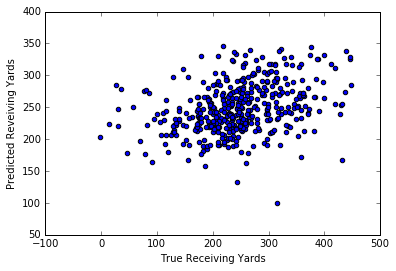

In [191]:
#Train a Linear regression model
Y_train=QB_training.apply(getStatRes,args=['passing_yds'],axis=1)
Y_cv=QB_cv.apply(getStatRes,args=['passing_yds'],axis=1)

from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

pass_pred = LinearRegression()
pass_pred.fit(X_train,Y_train)

#Check performance on CV data
plt.scatter(Y_cv, td_pred.predict(X_cv))
plt.xlabel("True Receiving Yards")
plt.ylabel("Predicted Reveiving Yards")


#Calculate mean squared error
mse = np.mean((Y_cv - pass_pred.predict(X_cv)) **2)
print 'MSE:', np.sqrt(mse)
print 'Average Yardage:', np.mean(Y_cv)
print 'Correlation: ', pearsonr(Y_cv,pass_pred.predict(X_cv))

MSE: 1.11853601567
Average Yardage: 1.61590909091
Correlation:  (0.26178116676055713, 2.5035067711783233e-08)


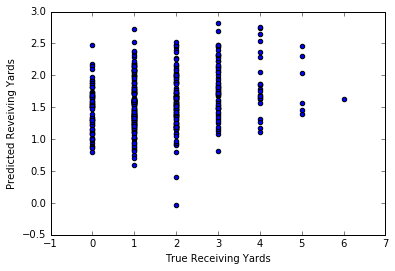

In [193]:
#Train a Linear regression model
Y_train=QB_training.apply(getStatRes,args=['passing_tds'],axis=1)
Y_cv=QB_cv.apply(getStatRes,args=['passing_tds'],axis=1)

from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

td_pred = LinearRegression()
td_pred.fit(X_train,Y_train)

#Check performance on CV data
plt.scatter(Y_cv, td_pred.predict(X_cv))
plt.xlabel("True Receiving Yards")
plt.ylabel("Predicted Reveiving Yards")


#Calculate mean squared error
mse = np.mean((Y_cv - td_pred.predict(X_cv)) **2)
print 'MSE:', np.sqrt(mse)
print 'Average Yardage:', np.mean(Y_cv)
print 'Correlation: ', pearsonr(Y_cv,td_pred.predict(X_cv))

# Test the result for fantasy points

In [194]:
#This is just a dumby place holder for now

def CalcFantasyPoints(pass_yds,tds):
    pass_pts = round(pass_yds/25)
    td_pts = tds*6   
    return pass_pts + td_pts

def EstiamteFantasyPoints(pass_yds,tds):
    pass_pts = pass_yds/25
    td_pts = tds*6
    return pass_pts + td_pts
   

In [211]:
Y_test_td=QB_cv.apply(getStatRes,args=['passing_tds'],axis=1)



440

MSE: 9.15700465807
Correlation:  (0.35689516661975218, 9.3982610820462299e-15)


(0, 40)

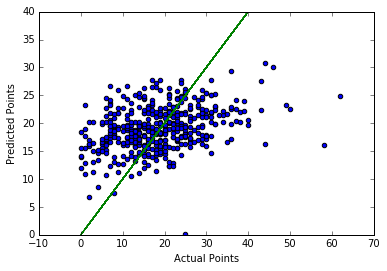

In [229]:
X_test=pd.DataFrame(QB_test.apply(getFeats,args=[all_feats],axis=1).tolist())
X_test.columns=getFeatNames(all_feats)
scaleFeat(X_test,all_feats)

Y_test_pass=QB_test.apply(getStatRes,args=['passing_yds'],axis=1)
Y_test_td=QB_test.apply(getStatRes,args=['passing_tds'],axis=1)

exp_pass = pass_pred.predict(X_test)
exp_td = td_pred.predict(X_test)

actual_pts=[]
pred_pts=[]

for row in range(len(exp_pass)):
    actual_pts.append( CalcFantasyPoints(Y_test_pass.iloc[row],Y_test_td.iloc[row]) )
    pred_pts.append( CalcFantasyPoints(exp_pass[row],exp_td[row]) )

plt.scatter(actual_pts, pred_pts)
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")


#Calculate mean squared error
mse = np.mean((np.array(actual_pts) - np.array(pred_pts)) **2)
print 'MSE:', np.sqrt(mse)
print 'Correlation: ', pearsonr(actual_pts,pred_pts)
plt.plot(actual_pts,actual_pts,color='g')
plt.ylim([0,40])